In [5]:
import cv2 #for resizing images
import numpy as np #for arrays
import os #for directories
from random import shuffle #to shuffle data
from tqdm import tqdm #for showing progress 

TRAIN_DIR = r"C:\Users\Suraj\Desktop\1\train" #train img data location
TEST_DIR = r"C:\Users\Suraj\Desktop\1\test" #test img data location
IMG_SIZE = 50 #size that images will resize to
LR = 0.001

MODEL_NAME = "dogsvscats-{}-{}.model".format(LR, "6conv-basic") #saves model with LR number of convolutional layers

In [6]:
#function that process the data to give labels to data
#data is named dog.12.jpg etc so split by -1 = png / -2 = 12 / -3 =dog
def label_img(img):
    word_label = img.split('.')[-3] #gets the label of the img by splitting file name so will be either cat or dog
    if word_label == "cat": return [1,0] #if the label on the image is cat, return with a one-hot value of 1,0
    elif word_label == "dog" :return [0,1] #if label is dog, return value 0,1

In [7]:
#function that creates processed image training data as numpy array and saves it
def create_train_data():
    training_data = [] #training data set to an empty list
    for img in tqdm(os.listdir(TRAIN_DIR)): #for each img in the training directory *tqdm allows to show graph can use w/o tqdm
        label = label_img(img) # takes in imgs & sets the labels by calling the label_img function for each img in training dir
        path = os.path.join(TRAIN_DIR,img) #joins the train dir & img giving full path of the image
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)#uses cv2 to read, resize and sets the image in grayscale as img
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)]) #makes the training data imgs and labels ands adds into arrays
    shuffle(training_data) #shuffles the training data
    np.save("train_data.npy", training_data) #saves the training_data as a numpy array
    return training_data

#only need to run this one time so file is saved, to reuse the the processed training data numpy array of images and labels of the data, or change processed data e.g. IMG_SIZE


In [8]:
#process the actual testing data without any labels data named 12.jpg etc.. look at above cell for full info as similar function
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split(".")[0] #gets img num from file name
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num]) #makes array of img and img_num
    np.save("test_data.npy", testing_data) #save test data
    return testing_data

In [9]:
# training_data = create_train_data() #creates training data and makes it to training_data variable use to create 
train_data = np.load("train_data.npy") #use to load training data if already created, file has to have same IMG_SIZE to work

In [10]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax') #number of classifications = 2 dog/cat
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets') #set hyperparameters e.g. learning rate

model = tflearn.DNN(convnet, tensorboard_dir="log") #creates the model and setup on tensorboard

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
#check to see if there is a trained saved model with existing weights and biases to allow training in future 
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("model got loaded")

INFO:tensorflow:Restoring parameters from C:\Users\Suraj\Desktop\1\dogsvscats-0.001-6conv-basic.model
model got loaded


In [12]:
#split up training data into training and testing data for testing accuracy of model
train = train_data[:-500] #training data of training data are all images + labels in array minus the last 500
test = train_data[-500:] #testing data of training data are -500 onwards

In [13]:
#get train and test data and reshape it for tflearn
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #feature sets, the 0 element in the array is the image data
Y = [i[1] for i in train] #labels at 1 element of array

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #feature sets, the 0 element in the array is the image data
test_y = [i[1] for i in test] #labels at 1 element of array

In [9]:
#training the cnn takes inputs and number of epochs and tests accuracy etc
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME) #run_id allows to find in tensorboard

Training Step: 1914  | total loss: 0.42160 | time: 14.829s
| Adam | epoch: 005 | loss: 0.42160 - acc: 0.8206 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.40866 | time: 15.871s
| Adam | epoch: 005 | loss: 0.40866 - acc: 0.8245 | val_loss: 0.50330 - val_acc: 0.7500 -- iter: 24500/24500
--


In [10]:
#run tensorboard command
#tensorboard --logdir=foo:C:\Users\Suraj\Desktop\1\log in cmd
# my link is http://desktop-309dfeq:6006
#model.save(MODEL_NAME) use to save model to be able to load in model for further training 

INFO:tensorflow:C:\Users\Suraj\Desktop\1\dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


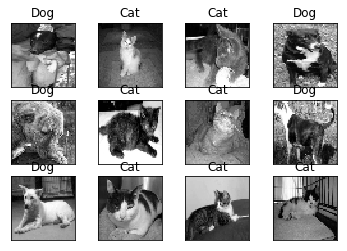

In [14]:
#just to see what the classifer classifies some images. USED TO PREDICT FOR ACTUAL TEST DATA
import matplotlib.pyplot as plt

#test_data = process_test_data() #used cresate test_data.npy array if not loaded test data
test_data = np.load("test_data.npy")

fig = plt.figure()

for num, data in enumerate(test_data[:12]): #get 1st 12  from array
    #cat = [1,0]
    #dog = [0,1]
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
    model_out = model.predict([data])[0] #uses the model to predict and pass in data and only want 0 element (img data) 
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    

In [15]:
#make function to save the results in csv file
with open("data-predictions.csv", "w") as f:
    f.write("id,label\n")

In [17]:
#write the data to the csv file
with open("data-predictions.csv", "w") as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write("{},{}\n".format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:42<00:00, 291.66it/s]
